In [20]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline 
import cv2 as cv
from IPython.display import Video
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
df = pd.read_csv('full_metadata.csv')

Comparing the amount of original vs deepfake videos in the dataset.

In [22]:
n_orig = df['original_file'].unique().shape[0]
n_fake = df['deepfake_file'].unique().shape[0]

print(f"Number of original videos: {n_orig}")
print(f"Number of deepfake videos: {n_fake}")

Number of original videos: 19154
Number of deepfake videos: 100000


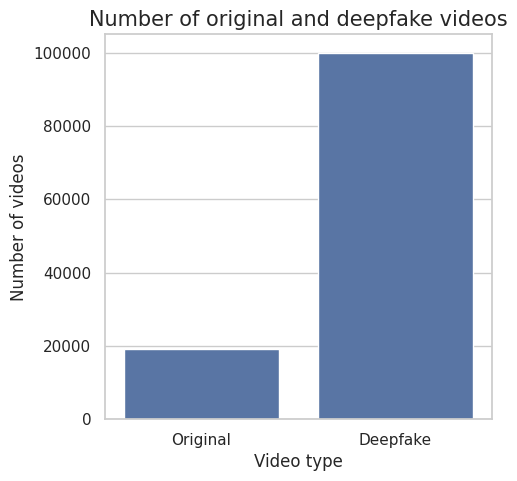

In [32]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.barplot(x=['Original', 'Deepfake'], y=[n_orig, n_fake], color="b")
plt.ylabel('Number of videos', fontsize=12)
plt.xlabel('Video type', fontsize=12)
plt.title('Number of original and deepfake videos', fontsize=15)
plt.show()

In [24]:
Video("sample_data/train_sample_videos/aagfhgtpmv.mp4")

In [35]:
df['original_file'].value_counts().head()

original_file
tfyyefqpfs.mp4    40
ypgayhhaxx.mp4    39
rqsotnryhj.mp4    39
zgdtjzfrad.mp4    39
gcyecnxtht.mp4    38
Name: count, dtype: int64